# Import Module and Data

In [1]:
#Import module yang dibutuhkan

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import plotly.express as px
import re

from gensim.models import Word2Vec
from tqdm import tqdm

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
!kaggle datasets download -d shudhanshusingh/az-medicine-dataset-of-india
!kaggle datasets download -d shudhanshusingh/250k-medicines-usage-side-effects-and-substitutes

!unzip az-medicine-dataset-of-india.zip
!unzip 250k-medicines-usage-side-effects-and-substitutes.zip

Dataset URL: https://www.kaggle.com/datasets/shudhanshusingh/az-medicine-dataset-of-india
License(s): CC-BY-SA-4.0
 61% 4.00M/6.60M [00:00<00:00, 6.04MB/s]
100% 6.60M/6.60M [00:01<00:00, 6.67MB/s]
Dataset URL: https://www.kaggle.com/datasets/shudhanshusingh/250k-medicines-usage-side-effects-and-substitutes
License(s): CC-BY-SA-4.0
 90% 13.0M/14.4M [00:01<00:00, 15.2MB/s]
100% 14.4M/14.4M [00:01<00:00, 10.9MB/s]
Archive:  az-medicine-dataset-of-india.zip
  inflating: A_Z_medicines_dataset_of_India.csv  
Archive:  250k-medicines-usage-side-effects-and-substitutes.zip
  inflating: medicine_dataset.csv    


In [3]:
az = pd.read_csv('/content/A_Z_medicines_dataset_of_India.csv')
med = pd.read_csv('/content/medicine_dataset.csv')

<ipython-input-3-f8bf86164f40>:2: DtypeWarning: Columns (42,43,44,45,46,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  med = pd.read_csv('/content/medicine_dataset.csv')


# Pre Processing & Data Cleaning

In [4]:
az.head()

,id,name,price(₹),Is_discontinued,manufacturer_name,type,pack_size_label,short_composition1,short_composition2
0,1,Augmentin 625 Duo Tablet,223.42,False,Glaxo SmithKline Pharmaceuticals Ltd,allopathy,strip of 10 tablets,Amoxycillin (500mg),Clavulanic Acid (125mg)
1,2,Azithral 500 Tablet,132.36,False,Alembic Pharmaceuticals Ltd,allopathy,strip of 5 tablets,Azithromycin (500mg),NaN
2,3,Ascoril LS Syrup,118.00,False,Glenmark Pharmaceuticals Ltd,allopathy,bottle of 100 ml Syrup,Ambroxol (30mg/5ml),Levosalbutamol (1mg/5ml)
3,4,Allegra 120mg Tablet,218.81,False,Sanofi India Ltd,allopathy,strip of 10 tablets,Fexofenadine (120mg),NaN
4,5,Avil 25 Tablet,10.96,False,Sanofi India Ltd,allopathy,strip of 15 tablets,Pheniramine (25mg),NaN


In [5]:
az.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253973 entries, 0 to 253972
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  253973 non-null  int64  
 1   name                253973 non-null  object 
 2   price(₹)            253973 non-null  float64
 3   Is_discontinued     253973 non-null  bool   
 4   manufacturer_name   253973 non-null  object 
 5   type                253973 non-null  object 
 6   pack_size_label     253973 non-null  object 
 7   short_composition1  253973 non-null  object 
 8   short_composition2  112171 non-null  object 
dtypes: bool(1), float64(1), int64(1), object(6)
memory usage: 15.7+ MB


In [6]:
med.head()

,id,name,substitute0,substitute1,substitute2,substitute3,substitute4,sideEffect0,sideEffect1,sideEffect2,...,sideEffect41,use0,use1,use2,use3,use4,Chemical Class,Habit Forming,Therapeutic Class,Action Class
0,1,augmentin 625 duo tablet,Penciclav 500 mg/125 mg Tablet,Moxikind-CV 625 Tablet,Moxiforce-CV 625 Tablet,Fightox 625 Tablet,Novamox CV 625mg Tablet,Vomiting,Nausea,Diarrhea,...,NaN,Treatment of Bacterial infections,NaN,NaN,NaN,NaN,NaN,No,ANTI INFECTIVES,NaN
1,2,azithral 500 tablet,Zithrocare 500mg Tablet,Azax 500 Tablet,Zady 500 Tablet,Cazithro 500mg Tablet,Trulimax 500mg Tablet,Vomiting,Nausea,Abdominal pain,...,NaN,Treatment of Bacterial infections,NaN,NaN,NaN,NaN,Macrolides,No,ANTI INFECTIVES,Macrolides
2,3,ascoril ls syrup,Solvin LS Syrup,Ambrodil-LX Syrup,Zerotuss XP Syrup,Capex LS Syrup,Broxum LS Syrup,Nausea,Vomiting,Diarrhea,...,NaN,Treatment of Cough with mucus,NaN,NaN,NaN,NaN,NaN,No,RESPIRATORY,NaN
3,4,allegra 120mg tablet,Lcfex Tablet,Etofex 120mg Tablet,Nexofex 120mg Tablet,Fexise 120mg Tablet,Histafree 120 Tablet,Headache,Drowsiness,Dizziness,...,NaN,Treatment of Sneezing and runny nose due to al...,Treatment of Allergic conditions,NaN,NaN,NaN,Diphenylmethane Derivative,No,RESPIRATORY,H1 Antihistaminics (second Generation)
4,5,avil 25 tablet,Eralet 25mg Tablet,NaN,NaN,NaN,NaN,Sleepiness,Dryness in mouth,NaN,...,NaN,Treatment of Allergic conditions,NaN,NaN,NaN,NaN,Pyridines Derivatives,No,RESPIRATORY,H1 Antihistaminics (First Generation)


In [7]:
med.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248218 entries, 0 to 248217
Data columns (total 58 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   id                 248218 non-null  int64 
 1   name               248218 non-null  object
 2   substitute0        238621 non-null  object
 3   substitute1        233867 non-null  object
 4   substitute2        230233 non-null  object
 5   substitute3        226856 non-null  object
 6   substitute4        223962 non-null  object
 7   sideEffect0        248218 non-null  object
 8   sideEffect1        238416 non-null  object
 9   sideEffect2        229500 non-null  object
 10  sideEffect3        207638 non-null  object
 11  sideEffect4        163560 non-null  object
 12  sideEffect5        131258 non-null  object
 13  sideEffect6        91857 non-null   object
 14  sideEffect7        67750 non-null   object
 15  sideEffect8        48506 non-null   object
 16  sideEffect9        3

In [8]:
az['price(₹)'].describe()

,price(₹)
count,253973.000000
mean,270.530844
std,3029.584134
min,0.000000
25%,48.000000
50%,79.000000
75%,140.000000
max,436000.000000


In [9]:
# Unique values az
print('Unique Values per Column:')
for i in az.columns:
    print(f'{i} → {az[i].nunique()}')

Unique Values per Column:
id → 253973
name → 249398
price(₹) → 20664
Is_discontinued → 2
manufacturer_name → 7648
type → 1
pack_size_label → 1929
short_composition1 → 8523
short_composition2 → 2980


In [10]:
# Unique values med
print('Unique Values per Column:')
for i in med.columns:
    print(f'{i} → {med[i].nunique()}')

Unique Values per Column:
id → 248218
name → 222825
substitute0 → 19374
substitute1 → 16309
substitute2 → 14289
substitute3 → 12774
substitute4 → 11688
sideEffect0 → 326
sideEffect1 → 334
sideEffect2 → 351
sideEffect3 → 362
sideEffect4 → 358
sideEffect5 → 324
sideEffect6 → 298
sideEffect7 → 274
sideEffect8 → 253
sideEffect9 → 231
sideEffect10 → 211
sideEffect11 → 181
sideEffect12 → 173
sideEffect13 → 144
sideEffect14 → 120
sideEffect15 → 94
sideEffect16 → 77
sideEffect17 → 65
sideEffect18 → 51
sideEffect19 → 41
sideEffect20 → 35
sideEffect21 → 29
sideEffect22 → 24
sideEffect23 → 17
sideEffect24 → 13
sideEffect25 → 10
sideEffect26 → 10
sideEffect27 → 9
sideEffect28 → 9
sideEffect29 → 8
sideEffect30 → 5
sideEffect31 → 5
sideEffect32 → 4
sideEffect33 → 3
sideEffect34 → 2
sideEffect35 → 1
sideEffect36 → 1
sideEffect37 → 1
sideEffect38 → 1
sideEffect39 → 1
sideEffect40 → 1
sideEffect41 → 1
use0 → 657
use1 → 334
use2 → 139
use3 → 74
use4 → 33
Chemical Class → 872
Habit Forming → 2
Therapeuti

In [11]:
# Hapus kolom id
az = az.drop(columns=['id'])
med = med.drop(columns=['id'])

## Duplikasi

In [12]:
# Cek jumlah data duplikat

duplicates1 = az.duplicated()
num_duplicates1 = duplicates1.sum()
print(f'Jumlah duplikasi dari dataset az: {num_duplicates1}')

duplicates2 = med.duplicated()
num_duplicates2 = duplicates2.sum()
print(f'Jumlah duplikasi dari dataset med: {num_duplicates2}')

Jumlah duplikasi dari dataset az: 5
Jumlah duplikasi dari dataset med: 24204


Terdapat duplikat pada masing-masing data. Duplikasi tersebut akan dihapus.

In [13]:
# Menghapus duplikasi di dataset az
az = az.drop_duplicates()

# Menghapus duplikasi di dataset med
med = med.drop_duplicates()

# Menampilkan hasil setelah duplikasi dihapus
print(f'\nJumlah baris setelah menghapus duplikasi di dataset az: {az.shape[0]}')
print(f'Jumlah baris setelah menghapus duplikasi di dataset med: {med.shape[0]}')

duplicates1 = az.duplicated()
num_duplicates1 = duplicates1.sum()
print(f'Jumlah duplikasi dari dataset az: {num_duplicates1}')

duplicates2 = med.duplicated()
num_duplicates2 = duplicates2.sum()
print(f'Jumlah duplikasi dari dataset med: {num_duplicates2}')


Jumlah baris setelah menghapus duplikasi di dataset az: 253968
Jumlah baris setelah menghapus duplikasi di dataset med: 224014
Jumlah duplikasi dari dataset az: 0
Jumlah duplikasi dari dataset med: 0


## Dataset az

#### Kolom "name" dengan value yang sama

In [14]:
# Menghitung jumlah unique value dari kolom 'name'
name_counts = az['name'].value_counts()

# Memfilter untuk hanya menampilkan nilai yang lebih dari 1
name_counts_filtered = name_counts[name_counts > 1]

# Mencetak unique value dan jumlahnya
print(name_counts_filtered)

name
NS 0.9% Infusion                  12
Ringer Lactate Infusion            7
Luligee Cream                      5
Azilife 500mg Tablet               5
Leflox 500mg Tablet                5
                                  ..
Ultravist 300mg I/ml Injection     2
Intor 80mg Tablet                  2
Orange CS Syrup                    2
Lodep 25mg Tablet                  2
Ceriz 5mg Syrup                    2
Name: count, Length: 4283, dtype: int64


In [15]:
az[az['name'] == "NS 0.9% Infusion"]

,name,price(₹),Is_discontinued,manufacturer_name,type,pack_size_label,short_composition1,short_composition2
152568,NS 0.9% Infusion,300.90,False,Claris Lifesciences Ltd,allopathy,bottle of 3000 ml Infusion,Sodium Chloride (0.9% w/v),NaN
152916,NS 0.9% Infusion,17.30,False,Nirlife Healthcare,allopathy,bottle of 100 ml Infusion,Sodium Chloride (0.9% w/v),NaN
154532,NS 0.9% Infusion,32.45,False,Claris Lifesciences Ltd,allopathy,bottle of 500 ml Infusion,Sodium Chloride (0.9% w/v),NaN
154733,NS 0.9% Infusion,17.65,False,Claris Lifesciences Ltd,allopathy,bottle of 100 ml Infusion,Sodium Chloride (0.9% w/v),NaN
154828,NS 0.9% Infusion,28.47,False,Otsuka Pharmaceuticals Pvt Ltd,allopathy,bottle of 500 ml Infusion,Sodium Chloride (0.9% w/v),NaN
155320,NS 0.9% Infusion,30.70,False,Nirlife Healthcare,allopathy,bottle of 500 ml Infusion,Sodium Chloride (0.9% w/v),NaN
155652,NS 0.9% Infusion,23.30,False,Nirlife Healthcare,allopathy,bottle of 250 ml Infusion,Sodium Chloride (0.9% w/v),NaN
155721,NS 0.9% Infusion,70.19,False,Fresenius Kabi India Pvt Ltd,allopathy,bottle of 500 ml Infusion,Sodium Chloride (0.9% w/v),NaN
156085,NS 0.9% Infusion,31.37,False,Amanta Healthcare Ltd,allopathy,bottle of 500 ml Infusion,Sodium Chloride (0.9% w/v),NaN
156522,NS 0.9% Infusion,17.33,False,Aculife Healthcare Private Limited,allopathy,bottle of 100 ml Infusion,Sodium Chloride (0.9% w/v),NaN


In [16]:
az[az['name'] == "Ringer Lactate Infusion"]

,name,price(₹),Is_discontinued,manufacturer_name,type,pack_size_label,short_composition1,short_composition2
186117,Ringer Lactate Infusion,22.50,False,Baxter India Pvt Ltd,allopathy,bottle of 500 ml Infusion,Sodium Chloride (0.600gm),Sodium Lactate (0.320gm)
188582,Ringer Lactate Infusion,46.11,False,Albert David Ltd,allopathy,bottle of 500 ml Infusion,Sodium Chloride (0.600gm),Sodium Lactate (0.320gm)
189321,Ringer Lactate Infusion,49.72,False,Otsuka Pharmaceutical India Pvt Ltd,allopathy,bottle of 500 ml Infusion,Sodium Chloride (0.6gm),Sodium Lactate (0.32gm)
189803,Ringer Lactate Infusion,49.73,False,Parenteral Drugs India Ltd,allopathy,bottle of 500 ml Infusion,Sodium Chloride (600mg),Sodium Lactate (320mg)
192464,Ringer Lactate Infusion,37.50,False,Otsuka Pharmaceutical India Pvt Ltd,allopathy,bottle of 1000 ml Infusion,Sodium Chloride (0.6gm),Sodium Lactate (0.32gm)
194320,Ringer Lactate Infusion,23.33,False,Parenteral Drugs India Ltd,allopathy,bottle of 1000 ml Infusion,Sodium Chloride (0.6gm),Sodium Lactate (0.32gm)
195433,Ringer Lactate Infusion,29.81,False,Nirlife Healthcare,allopathy,bottle of 500 ml Infusion,Sodium Chloride (0.600gm),Sodium Lactate (0.320gm)


Duplikasi pada nama obat dikarenakan obat diproduksi oleh manufaktur yang berbeda /dan memiliki ukuran yang berbeda (Clear)

#### Inkonsistensi penulisan "pack_size_label"

In [17]:
# Mengecek isi kolom pack_size_label

form=[]
count={}
for i in az.pack_size_label:
    words=i.split()
    x=words[-1].lower()
    if len(x)<=2:
        x=words[-2].lower()
    if x in form:
        count[x]+=1
    else:
        count[x]=1
        form.append(x)

sorted_count = dict(sorted(count.items(), key=lambda x:x[1], reverse=True))
sorted_count

{'tablets': 133631,
 'injection': 31907,
 'tablet': 18921,
 'syrup': 16741,
 'capsules': 15824,
 'suspension': 9166,
 'capsule': 6275,
 'cream': 5067,
 'drop': 3859,
 'solution': 1707,
 'gel': 1686,
 'ointment': 1669,
 'drops': 1423,
 'lotion': 1021,
 'infusion': 902,
 'soap': 526,
 'powder': 373,
 'spray': 366,
 'expectorant': 338,
 'shampoo': 270,
 'inhaler': 267,
 'kit': 248,
 'wash': 195,
 'liquid': 163,
 'injections': 137,
 'granules': 127,
 'respules': 122,
 'suppositories': 76,
 'rotacaps': 66,
 'sachet': 63,
 'gargle': 53,
 'patches': 47,
 'strips': 39,
 'syringe': 34,
 'paint': 34,
 'respicaps': 33,
 'suppository': 32,
 'inhalation': 29,
 'lozenges': 25,
 'strip': 25,
 'transcaps': 23,
 'emulsion': 22,
 'pessaries': 20,
 'transhaler': 20,
 'linctus': 19,
 'paste': 18,
 'patch': 18,
 'combikit': 17,
 'bottles': 16,
 'toothpaste': 16,
 'gums': 15,
 'combipack': 12,
 'suspensions': 12,
 'transpules': 12,
 'jelly': 11,
 'serum': 10,
 'lacquer': 9,
 'tabcaps': 9,
 'scrub': 9,
 'sol

In [18]:
# Mengurutkan berdasarkan abjad (key)
sorted_count_alpha = dict(sorted(count.items(), key=lambda x: x[0]))
# Menampilkan hasil yang sudah diurutkan berdasarkan abjad
sorted_count_alpha

{'aerosol': 1,
 'alicaps': 1,
 'ampules': 1,
 'aquanase': 2,
 'autohaler': 3,
 'autopen': 1,
 'bandage': 2,
 'bar': 3,
 'bio-adhesive': 2,
 'bottle': 1,
 'bottles': 16,
 'caplets': 5,
 'capsule': 6275,
 'capsules': 15824,
 'captabs': 2,
 'cartridge': 1,
 'cartriges': 6,
 'cleanser': 1,
 'combikit': 17,
 'combipack': 12,
 'conditioner': 2,
 'cream': 5067,
 'creams': 4,
 'diskettes': 3,
 'drop': 3859,
 'drops': 1423,
 'elixir': 3,
 'elixirs': 1,
 'emulsion': 22,
 'emulsions': 1,
 'enema': 7,
 'expectorant': 338,
 'film': 1,
 'foam': 9,
 'gargle': 53,
 'gel': 1686,
 'gels': 1,
 'grains': 2,
 'granules': 127,
 'gum': 2,
 'gummies': 2,
 'gums': 15,
 'husk': 6,
 'infusion': 902,
 'infusions': 1,
 'inhalation': 29,
 'inhaler': 267,
 'injection': 31907,
 'injections': 137,
 'instacap': 1,
 'instacaps': 4,
 'jelly': 11,
 'kit': 248,
 'lacquer': 9,
 'linctus': 19,
 'liniment': 7,
 'liquid': 163,
 'lotion': 1021,
 'lotions': 1,
 'lozenges': 25,
 'multihaler': 7,
 'nebulisers': 1,
 'nexcaps': 4,
 

Terdapat inkonsistensi (plural issue), seperti:
1. tablet dan tablets
2. bottle dan bottles
dst

Akan dihapus plural issue tersebut.

In [19]:
# Menghapus plural issue
final_count=sorted_count.copy()
for key,value in sorted_count.items():
    test=(key+'s') in final_count
    if test:
        final_count[key]+=final_count[key+'s']
        del final_count[key+'s']
        form.remove(key+'s')

final_count = dict(sorted(final_count.items(), key=lambda x:x[1], reverse=True))
final_count

{'tablet': 152552,
 'injection': 32044,
 'capsule': 22099,
 'syrup': 16747,
 'suspension': 9178,
 'drop': 5282,
 'cream': 5071,
 'solution': 1716,
 'gel': 1687,
 'ointment': 1669,
 'lotion': 1022,
 'infusion': 903,
 'soap': 526,
 'powder': 373,
 'spray': 366,
 'expectorant': 338,
 'shampoo': 271,
 'inhaler': 267,
 'kit': 248,
 'wash': 195,
 'liquid': 163,
 'granules': 127,
 'respules': 122,
 'suppositories': 76,
 'sachet': 70,
 'rotacaps': 66,
 'strip': 64,
 'gargle': 53,
 'patches': 47,
 'syringe': 35,
 'paint': 34,
 'respicaps': 33,
 'suppository': 32,
 'inhalation': 29,
 'lozenges': 25,
 'transcaps': 23,
 'emulsion': 23,
 'pessaries': 20,
 'transhaler': 20,
 'linctus': 19,
 'paste': 18,
 'patch': 18,
 'combikit': 17,
 'gum': 17,
 'bottle': 17,
 'toothpaste': 16,
 'combipack': 12,
 'transpules': 12,
 'jelly': 11,
 'serum': 10,
 'lacquer': 9,
 'tabcaps': 9,
 'scrub': 9,
 'foam': 9,
 'novocart': 8,
 'enema': 7,
 'liniment': 7,
 'multihaler': 7,
 'rheocap': 7,
 'husk': 6,
 'redicaps': 6

## Dataset med

#### Kolom "name" dengan value yang sama

In [20]:
# Menghitung jumlah unique value dari kolom 'name'
name_counts2 = med['name'].value_counts()

# Memfilter untuk hanya menampilkan nilai yang lebih dari 1
name_counts_filtered2 = name_counts2[name_counts2 > 1]

# Mencetak unique value dan jumlahnya
print(name_counts_filtered2)

name
ringer lactate infusion       4
cefpoxim dry syrup            4
azicon 500mg tablet           3
loxin 500mg tablet            3
kidivent-ls syrup             3
                             ..
fycare-d 30mg/20mg capsule    2
mytrip 25mg tablet            2
amcard 5 tablet               2
weldec 50mg injection         2
cypotin syrup                 2
Name: count, Length: 1165, dtype: int64


In [21]:
med[med['name'] == "ringer lactate infusion"]

,name,substitute0,substitute1,substitute2,substitute3,substitute4,sideEffect0,sideEffect1,sideEffect2,sideEffect3,...,sideEffect41,use0,use1,use2,use3,use4,Chemical Class,Habit Forming,Therapeutic Class,Action Class
199320,ringer lactate infusion,Ringer Lactate Infusion,Ringer Lactate IP Poly Infusion,RL Infusion,Ringer Lactate Infusion,NaN,No common side effects seen,NaN,NaN,NaN,...,NaN,Short term fluid replacement after trauma,NaN,NaN,NaN,NaN,NaN,No,BLOOD RELATED,NaN
201811,ringer lactate infusion,Ringer Lactate Infusion,Ringer Lactate Infusion,Ringer Lactate IP Poly Infusion,RL Infusion,NaN,No common side effects seen,NaN,NaN,NaN,...,NaN,Short term fluid replacement after trauma,NaN,NaN,NaN,NaN,NaN,No,BLOOD RELATED,NaN
202568,ringer lactate infusion,Ringer Lactate Infusion,RINGER LACTATE INFUSION,RINGER LACTATE INFUSION,NaN,NaN,No common side effects seen,NaN,NaN,NaN,...,NaN,Short term fluid replacement after trauma,NaN,NaN,NaN,NaN,NaN,No,BLOOD RELATED,NaN
203065,ringer lactate infusion,NaN,NaN,NaN,NaN,NaN,No common side effects seen,NaN,NaN,NaN,...,NaN,Short term fluid replacement after trauma,NaN,NaN,NaN,NaN,NaN,No,BLOOD RELATED,NaN


In [22]:
med[med['name'] == "ns 0.9% infusion"]

,name,substitute0,substitute1,substitute2,substitute3,substitute4,sideEffect0,sideEffect1,sideEffect2,sideEffect3,...,sideEffect41,use0,use1,use2,use3,use4,Chemical Class,Habit Forming,Therapeutic Class,Action Class
162750,ns 0.9% infusion,Normal Saline 0.9% Infusion,NS 1000ml Denis Infusion,N S 0.9% Infusion,NS 0.9% Infusion,NS 0.9% Infusion,"Injection site reactions (pain, swelling, redn...",Hypotension (low blood pressure),Fever,Tremors,...,NaN,Treatment of Short term fluid replacement afte...,Treatment of Dehydration,NaN,NaN,NaN,Alkali Metal Chlorides,No,RESPIRATORY,Crystalloids
166987,ns 0.9% infusion,NaN,NaN,NaN,NaN,NaN,"Injection site reactions (pain, swelling, redn...",Hypotension (low blood pressure),Fever,Tremors,...,NaN,Treatment of Short term fluid replacement afte...,Treatment of Dehydration,NaN,NaN,NaN,Alkali Metal Chlorides,No,RESPIRATORY,Crystalloids


Terdapat redudansi data. Solusi: Pilih 1 baris dengan data paling lengkap

In [23]:
# Solusi: Pilih 1 baris dengan data paling lengkap

# Menghitung jumlah nilai null untuk setiap baris
med['null_count'] = med.isnull().sum(axis=1)

# Mengurutkan berdasarkan kolom 'name' dan jumlah nilai null (ascending)
med_sorted = med.sort_values(by=['name', 'null_count'])

# Menghapus baris duplikat berdasarkan kolom 'name', menyisakan baris pertama (dengan nilai null paling sedikit)
med_cleaned = med_sorted.drop_duplicates(subset='name', keep='first')

# Menghapus kolom 'null_count' yang sudah tidak diperlukan
med = med_cleaned.drop(columns=['null_count'])

# Menghitung jumlah unique value dari kolom 'name'
name_counts2 = med['name'].value_counts()

# Memfilter untuk hanya menampilkan nilai yang lebih dari 1
name_counts_filtered2 = name_counts2[name_counts2 > 1]

# Mencetak unique value dan jumlahnya
print(name_counts_filtered2)

Series([], Name: count, dtype: int64)


### Kolom use

Kolom ini memiliki beberapa format penulisan kalimat yang berbeda, tetapi memiliki satu makna

In [24]:
med['use0'].value_counts()

,count
use0,
Treatment of Bacterial infections,34386
Pain relief,20570
Treatment of Type 2 diabetes mellitus,10093
Bacterial infections,9667
Treatment of Gastroesophageal reflux disease (Acid reflux),8942
...,...
Prevention of HPV-associated cancers,1
Benzodiazepine overdose,1
Diabetic macular edema (accumulation of fluid in eye of diabetic patients),1


Dapat dilihat 'Treatment of Bacterial infections' dan 'Bacterial infections' memiliki maksud yang sama tetapi penulisannya berbeda sehingga dihitung sebagai kategori yang berbeda.

Akan disamakan formatnya dengan menghilangkan extra word seperti treatment of atau prevention of, serta mengubahnya menjadi lower case.

In [25]:
def normalize_text(text):
    # Mengubah text menjadi huruf kecil
    text = text.lower()

    # Menghapus extra word seperti "treatment of", "prevention of", etc.
    text = re.sub(r'\b(treatment|prevention)\s*(of|and prevention of)?\b', '', text)

    return text.strip()

med['use0'] = [normalize_text(text) if isinstance(text, str) else text for text in med['use0']]
med['use1'] = [normalize_text(text) if isinstance(text, str) else text for text in med['use1']]
med['use2'] = [normalize_text(text) if isinstance(text, str) else text for text in med['use2']]
med['use3'] = [normalize_text(text) if isinstance(text, str) else text for text in med['use3']]
med['use4'] = [normalize_text(text) if isinstance(text, str) else text for text in med['use4']]

In [26]:
med['use0'].value_counts()

,count
use0,
bacterial infections,44053
pain relief,20578
gastroesophageal reflux disease (acid reflux),10867
type 2 diabetes mellitus,10099
hypertension (high blood pressure),10088
...,...
hairy cell leukemia,1
pruritus,1
localized muscle spasm,1


### Missing Value

In [27]:
az.isnull().mean() * 100

,0
name,0.000000
price(₹),0.000000
Is_discontinued,0.000000
manufacturer_name,0.000000
type,0.000000
pack_size_label,0.000000
short_composition1,0.000000
short_composition2,55.833412


Terdapat missing value di dataset az pada kolom short_composition2. Namun, tidak akan kami hapus karena kolom ini cukup penting (berkaitan dengan komposisi obat).

In [28]:
med.isnull().mean() * 100

,0
name,0.000000
substitute0,3.921014
substitute1,5.870526
substitute2,7.377090
substitute3,8.766072
substitute4,9.957141
sideEffect0,0.000000
sideEffect1,4.008976
sideEffect2,7.577696
sideEffect3,16.311904


Terdapat missing value di dataset med. Namun, untuk saat ini tidak akan kami hapus dahulu.

## Kolom baru

Membuat beberapa kolom baru untuk dataset az

**type**: jenis obat (tablet, syrup, dll.)

**primary_comp**: komposisi utama obat dari kolom 'short_composition1'

**entire_comp**: 'primary_comp' + komposisi obat dari 'short_composition2'

**value**: ukuran komposisi 'short_composition1' (Eg: 500mg)

**entire_value**: value + ukuran komposisi dari 'short_composition2' (Eg: 125mg)

In [29]:
# Dataset az

def getType(row):
    for type in form:
        if type in row['pack_size_label'].lower():
            return type
def getComp(row):
    return row['short_composition1'].split('(')[0].lower().rstrip()

def getValue(row):
    return row['short_composition1'].split('(')[1].lower().rstrip().rstrip(')')


az['type'] = az.apply(lambda row: getType(row), axis=1)
az['primary_comp'] = az.apply(lambda row: getComp(row), axis=1)
az['entire_comp'] = az['primary_comp'] + ' ' + np.where(az['short_composition2'].isna(), '',
                                                         az['short_composition2'].astype(str).apply(lambda x: x.split('(')[0].lower().rstrip().replace(' ', '')))
az['value'] = az.apply(lambda row: getValue(row), axis=1)
az['entire_value'] =  az['value'] + ' ' + np.where(az['short_composition2'].isna(), '',
                                                   az['short_composition2'].astype(str).apply(lambda x: x.split('(')[1].lower().rstrip().rstrip(')') if len(x.split('(')) > 1 else ''))

az.head()

,name,price(₹),Is_discontinued,manufacturer_name,type,pack_size_label,short_composition1,short_composition2,primary_comp,entire_comp,value,entire_value
0,Augmentin 625 Duo Tablet,223.42,False,Glaxo SmithKline Pharmaceuticals Ltd,tablet,strip of 10 tablets,Amoxycillin (500mg),Clavulanic Acid (125mg),amoxycillin,amoxycillin clavulanicacid,500mg,500mg 125mg
1,Azithral 500 Tablet,132.36,False,Alembic Pharmaceuticals Ltd,tablet,strip of 5 tablets,Azithromycin (500mg),NaN,azithromycin,azithromycin,500mg,500mg
2,Ascoril LS Syrup,118.00,False,Glenmark Pharmaceuticals Ltd,syrup,bottle of 100 ml Syrup,Ambroxol (30mg/5ml),Levosalbutamol (1mg/5ml),ambroxol,ambroxol levosalbutamol,30mg/5ml,30mg/5ml 1mg/5ml
3,Allegra 120mg Tablet,218.81,False,Sanofi India Ltd,tablet,strip of 10 tablets,Fexofenadine (120mg),NaN,fexofenadine,fexofenadine,120mg,120mg
4,Avil 25 Tablet,10.96,False,Sanofi India Ltd,tablet,strip of 15 tablets,Pheniramine (25mg),NaN,pheniramine,pheniramine,25mg,25mg


Membuat beberapa kolom baru untuk dataset med

**main_subs**: substitusi obat dari 'substitute0'

**other_subs**: substitusi obat dari kolom selain 'substitute0'

**sideeffects**: efek samping obat dari kolom sideEffect1-sideEffect41

**use**: kegunaan obat dari kolom use0-use4

In [30]:
# Dataset med

med['main_subs'] = med.apply(lambda row: row['substitute0'] if not pd.isna(row['substitute0']) else '', axis=1)

med['other_subs'] = med.apply(lambda row: ', '.join(set([str(row['substitute{}'.format(i)]) for i in range(1, 5)\
                                                     if not pd.isna(row['substitute{}'.format(i)])])), axis=1)

med['sideeffects'] = med.apply(lambda row: ', '.join(set([str(row['sideEffect{}'.format(i)]) for i in range(42)\
                                                     if not pd.isna(row['sideEffect{}'.format(i)])])), axis=1)

med['use'] = med.apply(lambda row: ' '.join([str(row['use{}'.format(i)]).replace(' ', '') for i in range(5) \
                                             if not pd.isna(row['use{}'.format(i)])]), axis=1)
med.head()

,name,substitute0,substitute1,substitute2,substitute3,substitute4,sideEffect0,sideEffect1,sideEffect2,sideEffect3,...,use3,use4,Chemical Class,Habit Forming,Therapeutic Class,Action Class,main_subs,other_subs,sideeffects,use
996,Alto's citrasol liquid,Cadicitron 1.4gm/5ml Syrup,Acrocitron 1.4gm/5ml Syrup,Alkacit Syrup,Alkawin 1.4gm/5ml Syrup,Citodac Syrup,Stomach pain,Tiredness,Diarrhea,Nausea,...,NaN,NaN,Carboxylic acid derivative,No,UROLOGY,Uricosuric agent-gout,Cadicitron 1.4gm/5ml Syrup,"Citodac Syrup, Acrocitron 1.4gm/5ml Syrup, Alk...","Stomach pain, Nausea, Tiredness, Frequent urge...",gout kidneystone
6434,a 1 5mg tablet,StayHappi Amlodipine 5mg Tablet,Amlip 5 Tablet,Avacard 5mg Tablet,Amcard 5 Tablet,Amlong Tablet,Headache,Fatigue,Nausea,Abdominal pain,...,NaN,NaN,Dihydropyridinecarboxylic acids derivatives,No,CARDIAC,Calcium channel blockers- Dihydropyridines (DHP),StayHappi Amlodipine 5mg Tablet,"Amcard 5 Tablet, Amlong Tablet, Amlip 5 Tablet...","Sleepiness, Headache, Nausea, Fatigue, Abdomin...",hypertension(highbloodpressure) angina(heart-r...
6139,a 250 suspension,Rakbi 250mg Suspension,Alcocin Suspension,Tempros Suspension,Mormol 250mg Suspension,Jetmol Suspension,Indigestion,Stomach pain,Nausea,Vomiting,...,NaN,NaN,P-Aminophenol Derivative,No,PAIN ANALGESICS,Analgesic & Antipyretic-PCM,Rakbi 250mg Suspension,"Jetmol Suspension, Tempros Suspension, Mormol ...","Vomiting, Nausea, Indigestion, Stomach pain",painrelief fever
13016,a 3 100 mg/500 mg tablet,Nimsa Plus 100mg/500mg Tablet,Nicet Tablet,Nesu P 100mg/500mg Tablet,Nimeson P 100 mg/500 mg Tablet,Tromanil Plus 100 mg/500 mg Tablet,Nausea,Vomiting,Diarrhea,Increased liver enzymes,...,NaN,NaN,NaN,No,PAIN ANALGESICS,NaN,Nimsa Plus 100mg/500mg Tablet,"Nesu P 100mg/500mg Tablet, Nimeson P 100 mg/50...","Vomiting, Nausea, Diarrhea, Increased liver en...",painrelief
14692,a arti 60mg injection,Arteross 60mg Injection,Falciart 60mg Injection,Falsitis AR Injection,Leonate 60mg Injection,Neosunate 60mg Injection,Headache,Dizziness,Weakness,Loss of appetite,...,NaN,NaN,Sesquiterpene lactones,No,ANTI MALARIALS,Antimalarial- Artemisinin and derivatives,Arteross 60mg Injection,"Neosunate 60mg Injection, Falsitis AR Injectio...","Dizziness, Headache, Weakness, Loss of appetit...",malaria


## Merge Dataset

Belum tentu name pada az ada pada med dan sebaliknya. Karena kualitas data az dinilai lebih baik daripada med, akan dilakukan left join.

In [31]:
# Melakukan merge dataset az dan med berdasarkan kolom 'name' dengan menyesuaikan casing secara sementara
df = pd.merge(az, med, left_on=az['name'].str.lower(), right_on='name', how='left', indicator=True)

# Mengecek baris dari az yang tidak memiliki pasangan di med
unmatched_rows = df[df['_merge'] == 'left_only']

In [32]:
# Menampilkan jumlah baris yang tidak memiliki pasangan di med
percentage_unmatched = (len(unmatched_rows) / len(df)) * 100
print(f'Persentase unmatched rows dari keseluruhan: {percentage_unmatched:.2f}%')
print(f'Jumlah baris dari az yang tidak memiliki pasangan di med: {len(unmatched_rows)}')

# Menampilkan beberapa baris pertama dari hasil yang tidak memiliki pasangan
unmatched_rows.head()

Persentase unmatched rows dari keseluruhan: 11.06%
Jumlah baris dari az yang tidak memiliki pasangan di med: 28092


,name,name_x,price(₹),Is_discontinued,manufacturer_name,type,pack_size_label,short_composition1,short_composition2,primary_comp,...,use4,Chemical Class,Habit Forming,Therapeutic Class,Action Class,main_subs,other_subs,sideeffects,use,_merge
75,amaryl 1mg tablet,Amaryl 1mg Tablet,133.81,False,Sanofi India Ltd,tablet,strip of 30 tablets,Glimepiride (1mg),NaN,glimepiride,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
121,amaryl 2mg tablet,Amaryl 2mg Tablet,212.65,False,Sanofi India Ltd,tablet,strip of 30 tablets,Glimepiride (2mg),NaN,glimepiride,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
411,amaryl 3mg tablet,Amaryl 3mg Tablet,438.43,False,Sanofi India Ltd,tablet,strip of 30 tablets,Glimepiride (3mg),NaN,glimepiride,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
524,azulix 1 tablet,Azulix 1 Tablet,44.47,False,Torrent Pharmaceuticals Ltd,tablet,strip of 10 tablets,Glimepiride (1mg),NaN,glimepiride,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
594,azulix 2 tablet,Azulix 2 Tablet,70.65,False,Torrent Pharmaceuticals Ltd,tablet,strip of 10 tablets,Glimepiride (2mg),NaN,glimepiride,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


Persentase baris yang tidak memiliki pasangan adalah 11.06%, cukup banyak tapi masih di bawah 50% sehingga akan dibiarkan.

In [33]:
df.head()

,name,name_x,price(₹),Is_discontinued,manufacturer_name,type,pack_size_label,short_composition1,short_composition2,primary_comp,...,use4,Chemical Class,Habit Forming,Therapeutic Class,Action Class,main_subs,other_subs,sideeffects,use,_merge
0,augmentin 625 duo tablet,Augmentin 625 Duo Tablet,223.42,False,Glaxo SmithKline Pharmaceuticals Ltd,tablet,strip of 10 tablets,Amoxycillin (500mg),Clavulanic Acid (125mg),amoxycillin,...,NaN,NaN,No,ANTI INFECTIVES,NaN,Penciclav 500 mg/125 mg Tablet,"Moxiforce-CV 625 Tablet, Fightox 625 Tablet, N...","Vomiting, Nausea, Diarrhea",bacterialinfections,both
1,azithral 500 tablet,Azithral 500 Tablet,132.36,False,Alembic Pharmaceuticals Ltd,tablet,strip of 5 tablets,Azithromycin (500mg),NaN,azithromycin,...,NaN,Macrolides,No,ANTI INFECTIVES,Macrolides,Zithrocare 500mg Tablet,"Cazithro 500mg Tablet, Azax 500 Tablet, Zady 5...","Vomiting, Nausea, Diarrhea, Abdominal pain",bacterialinfections,both
2,ascoril ls syrup,Ascoril LS Syrup,118.00,False,Glenmark Pharmaceuticals Ltd,syrup,bottle of 100 ml Syrup,Ambroxol (30mg/5ml),Levosalbutamol (1mg/5ml),ambroxol,...,NaN,NaN,No,RESPIRATORY,NaN,Solvin LS Syrup,"Zerotuss XP Syrup, Capex LS Syrup, Ambrodil-LX...","Dizziness, Stomach pain, Tremors, Headache, Ra...",coughwithmucus,both
3,allegra 120mg tablet,Allegra 120mg Tablet,218.81,False,Sanofi India Ltd,tablet,strip of 10 tablets,Fexofenadine (120mg),NaN,fexofenadine,...,NaN,Diphenylmethane Derivative,No,RESPIRATORY,H1 Antihistaminics (second Generation),Lcfex Tablet,"Fexise 120mg Tablet, Histafree 120 Tablet, Nex...","Drowsiness, Dizziness, Nausea, Headache",sneezingandrunnynoseduetoallergies allergiccon...,both
4,avil 25 tablet,Avil 25 Tablet,10.96,False,Sanofi India Ltd,tablet,strip of 15 tablets,Pheniramine (25mg),NaN,pheniramine,...,NaN,Pyridines Derivatives,No,RESPIRATORY,H1 Antihistaminics (First Generation),Eralet 25mg Tablet,,"Dryness in mouth, Sleepiness",allergicconditions,both


In [34]:
# Missing Value
df.isnull().mean() * 100

,0
name,0.000000
name_x,0.000000
price(₹),0.000000
Is_discontinued,0.000000
manufacturer_name,0.000000
...,...
main_subs,11.061236
other_subs,11.061236
sideeffects,11.061236
use,11.061236


In [35]:
# Drop kolom yang tidak dibutuhkan
df = df.drop(columns=['_merge', 'short_composition1', 'short_composition2','name_x','name_y'])
df.head()

,name,price(₹),Is_discontinued,manufacturer_name,type,pack_size_label,primary_comp,entire_comp,value,entire_value,...,use3,use4,Chemical Class,Habit Forming,Therapeutic Class,Action Class,main_subs,other_subs,sideeffects,use
0,augmentin 625 duo tablet,223.42,False,Glaxo SmithKline Pharmaceuticals Ltd,tablet,strip of 10 tablets,amoxycillin,amoxycillin clavulanicacid,500mg,500mg 125mg,...,NaN,NaN,NaN,No,ANTI INFECTIVES,NaN,Penciclav 500 mg/125 mg Tablet,"Moxiforce-CV 625 Tablet, Fightox 625 Tablet, N...","Vomiting, Nausea, Diarrhea",bacterialinfections
1,azithral 500 tablet,132.36,False,Alembic Pharmaceuticals Ltd,tablet,strip of 5 tablets,azithromycin,azithromycin,500mg,500mg,...,NaN,NaN,Macrolides,No,ANTI INFECTIVES,Macrolides,Zithrocare 500mg Tablet,"Cazithro 500mg Tablet, Azax 500 Tablet, Zady 5...","Vomiting, Nausea, Diarrhea, Abdominal pain",bacterialinfections
2,ascoril ls syrup,118.00,False,Glenmark Pharmaceuticals Ltd,syrup,bottle of 100 ml Syrup,ambroxol,ambroxol levosalbutamol,30mg/5ml,30mg/5ml 1mg/5ml,...,NaN,NaN,NaN,No,RESPIRATORY,NaN,Solvin LS Syrup,"Zerotuss XP Syrup, Capex LS Syrup, Ambrodil-LX...","Dizziness, Stomach pain, Tremors, Headache, Ra...",coughwithmucus
3,allegra 120mg tablet,218.81,False,Sanofi India Ltd,tablet,strip of 10 tablets,fexofenadine,fexofenadine,120mg,120mg,...,NaN,NaN,Diphenylmethane Derivative,No,RESPIRATORY,H1 Antihistaminics (second Generation),Lcfex Tablet,"Fexise 120mg Tablet, Histafree 120 Tablet, Nex...","Drowsiness, Dizziness, Nausea, Headache",sneezingandrunnynoseduetoallergies allergiccon...
4,avil 25 tablet,10.96,False,Sanofi India Ltd,tablet,strip of 15 tablets,pheniramine,pheniramine,25mg,25mg,...,NaN,NaN,Pyridines Derivatives,No,RESPIRATORY,H1 Antihistaminics (First Generation),Eralet 25mg Tablet,,"Dryness in mouth, Sleepiness",allergicconditions


Untuk model, hanya akan digunakan obat yang hingga saat ini masih diproduksi (tidak discontinue).

In [36]:
# Dataset final
df_final = df[df.Is_discontinued==False]
df_final = df_final[['name','type',	'primary_comp',	'entire_comp',
                     'value',	'entire_value',	'use']]
df_final.head()

,name,type,primary_comp,entire_comp,value,entire_value,use
0,augmentin 625 duo tablet,tablet,amoxycillin,amoxycillin clavulanicacid,500mg,500mg 125mg,bacterialinfections
1,azithral 500 tablet,tablet,azithromycin,azithromycin,500mg,500mg,bacterialinfections
2,ascoril ls syrup,syrup,ambroxol,ambroxol levosalbutamol,30mg/5ml,30mg/5ml 1mg/5ml,coughwithmucus
3,allegra 120mg tablet,tablet,fexofenadine,fexofenadine,120mg,120mg,sneezingandrunnynoseduetoallergies allergiccon...
4,avil 25 tablet,tablet,pheniramine,pheniramine,25mg,25mg,allergicconditions


In [37]:
# Missing Value
missing_values = df_final.isnull().sum()
percentage_missing = (missing_values / len(df_final)) * 100

missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': percentage_missing})
print(missing_data)

              Missing Values  Percentage
name                       0    0.000000
type                       0    0.000000
primary_comp               0    0.000000
entire_comp                0    0.000000
value                      0    0.000000
entire_value               0    0.000000
use                    27456   11.158118


Terdapat missing value pada kolom use yang akan dihapus.

In [38]:
df_final = df_final.dropna(subset=['use'])

#EDA

In [39]:
# Total unique medicine
unique_drugs = df['name'].unique()
unique_uses = df['use0'].unique()
unique_chem = df['Chemical Class'].unique()
unique_side = df['sideEffect0'].unique()

print(f"Number of unique drugs: {len(unique_drugs)}")
print(f"Total data rows: {df.shape[0]}")
print(f"Number of unique uses: {len(unique_uses)}")
print(f"Number of unique chemical class: {len(unique_chem)}")
print(f"Number of unique side effect: {len(unique_side)}")

Number of unique drugs: 249345
Total data rows: 253968
Number of unique uses: 456
Number of unique chemical class: 872
Number of unique side effect: 326


In [40]:
df['sideEffect0'].value_counts()


,count
sideEffect0,
Nausea,61930
Diarrhea,21756
Headache,15503
Vomiting,13366
Rash,10083
...,...
Transient increase in white blood cell count (eosinophils),1
Uterine bleeding,1
Systemic lupus erythematosus,1


## Top 10 Medicine Manufacturers

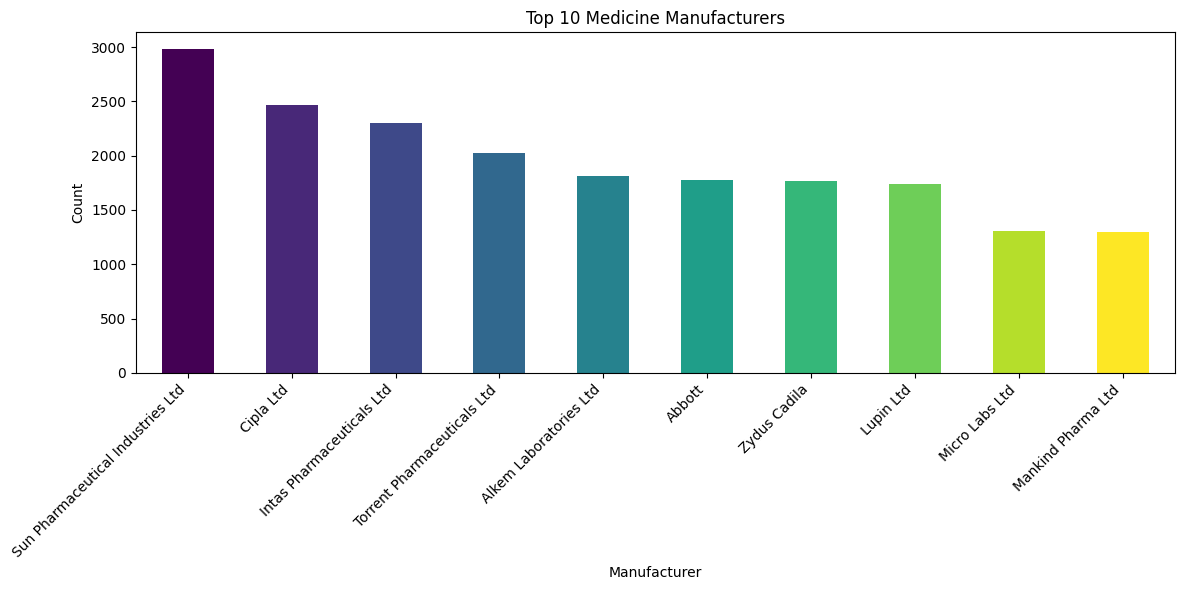

In [41]:
plt.figure(figsize=(12, 6))
colors = plt.cm.viridis(np.linspace(0, 1, 10))
df['manufacturer_name'].value_counts().nlargest(10).plot(kind='bar', color=colors)
plt.title('Top 10 Medicine Manufacturers')
plt.xlabel('Manufacturer')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [42]:
top_10_manufacturers = df['manufacturer_name'].value_counts().nlargest(10)
df_top_10 = df[df['manufacturer_name'].isin(top_10_manufacturers.index)]
columns = ['use0', 'primary_comp', 'Chemical Class', 'Action Class', 'Therapeutic Class', 'type']
figs = []

for column in columns:
    fig = px.bar(df_top_10[column].value_counts()[:5], color=df_top_10[column].value_counts()[:5], color_continuous_scale='sunset')
    fig.update_layout(
        title=f'Distibution of Features',
        xaxis_title=' ',
        yaxis_title='Count',
        plot_bgcolor='white'
    )
    figs.append(fig)

# Membuat tombol interaktif
buttons = []
for i, column in enumerate(columns):
    for manufacturer in top_10_manufacturers.index:
        button = dict(
            label=f"{column} - {manufacturer}",
            method='update',
            args=[{'y': [df[df["manufacturer_name"]==manufacturer][column].value_counts()[:5].values],
                   'x':[df[df["manufacturer_name"]==manufacturer][column].value_counts()[:5].index]}],
        )
        buttons.append(button)

# Menambahkan tombol ke layout
figs[0].update_layout(
    updatemenus=[
        dict(
            buttons=buttons,
            direction='down',
            showactive=True
        )
    ]
)

figs[0].show()



*  Semua perusahaan yang berada pada daftar 'Top 10 Medicine Manufacturers' umumnya menjual obatnya dalam bentuk tablet
*   Semua perusahaan kecuali Intas Pharmaceuticals Ltd dan Torrent Pharmaceuticals Ltd paling banyak menjual obat untuk mengobati infeksi bakteri, bahkan 'bacterial infectiona' masih berada tetap berada pada posisi 5 teratas di kedua company tersebut. Hal ini tentu wajar mengingat banyak penyakit yang disebabkan oleh serangan bakteri
*   Dari bar chart di atas dapat juga disimpulkan bahwa masing-masing perusahaan memproduksi obat yang beragam, tidak terdapat kriteria tertentu atau perusahaan yang lebih menonjol dalam satu bidang

## Top 10 Most Expensive Medicine

<Figure size 1200x600 with 0 Axes>

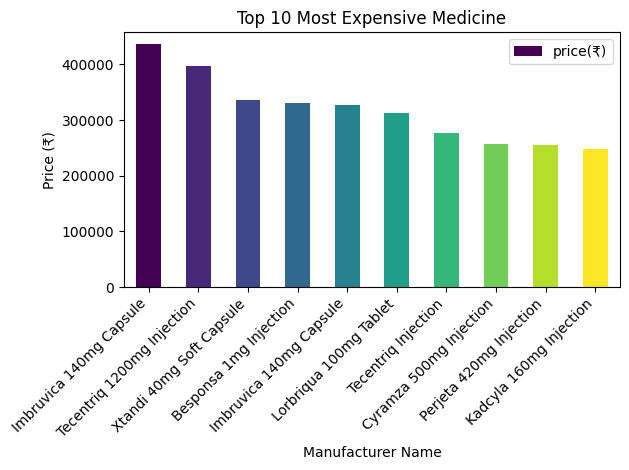

In [43]:
plt.figure(figsize=(12, 6))
colors = plt.cm.viridis(np.linspace(0, 1, 10))
az.sort_values('price(₹)', ascending=False).head(10).plot(x='name', y='price(₹)', kind='bar', color=colors)
plt.title('Top 10 Most Expensive Medicine')
plt.xlabel('Manufacturer Name')
plt.ylabel('Price (₹)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [44]:
# Mengambil 10 obat termahal
top_10_expensive = df.sort_values('price(₹)', ascending=False).head(10)

# Membuat DataFrame baru dengan kolom yang diinginkan
result_df = top_10_expensive[['name','use', 'pack_size_label', 'type', 'primary_comp']]

result_df

,name,use,pack_size_label,type,primary_comp
113861,imbruvica 140mg capsule,mantle-celllymphoma bloodcancer(chroniclymphoc...,bottle of 120 capsules,capsule,ibrutinib
217017,tecentriq 1200mg injection,smallcelllungcancer non-smallcelllungcancer me...,vial of 20 ml Solution for Infusion,solution,atezolizumab
243966,xtandi 40mg soft capsule,prostatecancer,bottle of 112 capsules,capsule,enzalutamide
28711,besponsa 1mg injection,acutelymphoblasticleukemia,vial of 1 Injection,injection,inotuzumab ozogamacin
113860,imbruvica 140mg capsule,mantle-celllymphoma bloodcancer(chroniclymphoc...,bottle of 90 capsules,capsule,ibrutinib
129168,lorbriqua 100mg tablet,non-smallcelllungcancer,box of 30 tablets,tablet,lorlatinib
219477,tecentriq injection,smallcelllungcancer non-smallcelllungcancer me...,vial of 14 ml Injection,injection,atezolizumab
35994,cyramza 500mg injection,non-smallcelllungcancer stomachcancer cancerof...,vial of 50 ml Injection,injection,ramucirumab
175272,perjeta 420mg injection,breastcancer,vial of 14 ml Injection,injection,pertuzumab
116433,kadcyla 160mg injection,earlybreastcancer metastaticbreastcancer,vial of 1 Injection,injection,ado-trastuzumab emtansine


*   Dapat dilihat kesamaan dari semua obat yang termasuk ke dalam 'Top 10 Most Expensive Medicine' yaitu use atau kegunaannya untuk perawatan kanker. Kanker termasuk ke dalam penyakit ganas yang sulit disembuhkan, hal ini membuat para peniliti terus berusaha untuk mencari solusi pengobatannya, biaya uji klinis yang mahal, serta harga pasar dari obat kanker yang memang di atas rata-rata membuat setiap terdapat obat kanker baru di pasaran harganya akan melonjak naik.
*   Selain itu harga juga dipengaruhi oleh size dari kemasannya, obat yang sama tetapi sizenya berbeda, maka harganya juga akan berbeda. Misal pada list di atas, 'imbruvica 140mg capsule' botol berisi 120 kapsul lebih mahal dari yang isi 90 kapsul karena isinya lebih banyak

## Habit Forming

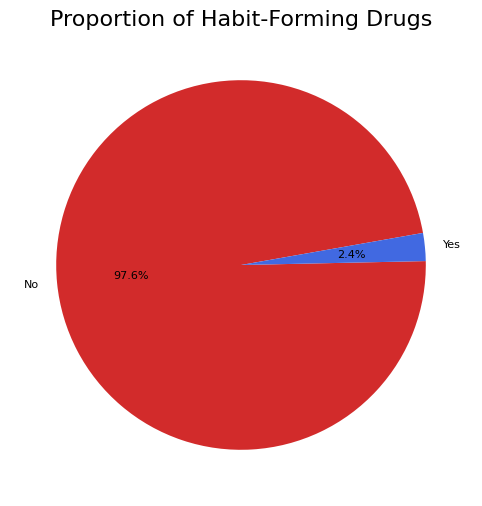

In [45]:
habit_counts = df['Habit Forming'].value_counts()
colors = ['#D22B2B','#4169E1']

# Pie Chart
plt.figure(figsize=(8, 6))
plt.pie(habit_counts, labels=habit_counts.index, autopct=lambda p : '{:.1f}%'.format(p), startangle=10, colors=colors, textprops={'fontsize': 8})
plt.title('Proportion of Habit-Forming Drugs', fontsize=16)
plt.show()

In [46]:
df_habit = df[df['Habit Forming'] == 'Yes']
df_habit.head()

,name,price(₹),Is_discontinued,manufacturer_name,type,pack_size_label,primary_comp,entire_comp,value,entire_value,...,use3,use4,Chemical Class,Habit Forming,Therapeutic Class,Action Class,main_subs,other_subs,sideeffects,use
21,alprax 0.25 tablet,29.00,False,Torrent Pharmaceuticals Ltd,tablet,strip of 15 tablets,alprazolam,alprazolam,0.25mg,0.25mg,...,NaN,NaN,Benzodiazepines Derivative,Yes,NEURO CNS,Benzodiazepines,Alltop 0.25mg Tablet,"Exal 0.25mg Tablet, Nindra 0.25mg Tablet, Alpr...","Drowsiness, Lightheadedness",anxiety panicdisorder
23,ativan 2mg tablet,91.87,False,Pfizer Ltd,tablet,strip of 30 tablets,lorazepam,lorazepam,2mg,2mg,...,NaN,NaN,Benzodiazepines Derivative,Yes,RESPIRATORY,Benzodiazepines,Zepnap 2mg Tablet,"Larpose 2mg Tablet, Texina 2mg Tablet, Zelor 2...","Balance disorder (loss of balance), Dizziness,...",shorttermanxiety anxietydisorder
34,ativan 1mg tablet,75.67,False,Pfizer Ltd,tablet,strip of 30 tablets,lorazepam,lorazepam,1mg,1mg,...,NaN,NaN,Benzodiazepines Derivative,Yes,RESPIRATORY,Benzodiazepines,Lzepam 1mg Tablet,"Zepnap 1mg Tablet, Lorel 1mg Tablet, Lopam 1mg...","Balance disorder (loss of balance), Dizziness,...",shorttermanxiety anxietydisorder
38,alprax 0.5mg tablet,66.90,False,Torrent Pharmaceuticals Ltd,tablet,strip of 15 tablets,alprazolam,alprazolam,0.5mg,0.5mg,...,NaN,NaN,Benzodiazepines Derivative,Yes,NEURO CNS,Benzodiazepines,Alprasafe 0.5mg Tablet,"Zolipax 0.5mg Tablet, Alparazole 0.5mg Tablet,...","Drowsiness, Lightheadedness",anxiety panicdisorder
61,amixide-h tablet,51.00,False,Sun Pharmaceutical Industries Ltd,tablet,strip of 10 tablets,amitriptyline,amitriptyline chlordiazepoxide,12.5mg,12.5mg 5mg,...,NaN,NaN,NaN,Yes,NEURO CNS,NaN,Trixide-H Tablet,"Trixide 12.5 mg/5 mg Tablet, Kimitrip 12.5mg/5...","Confusion, Depression, Blurred vision, Weight ...",depression


In [47]:
df_habit.loc[df_habit['use0'] == 'Treatment of Anxiety disorder', 'use0'] = ' Anxiety disorder'
df_habit.loc[df_habit['use0'] == 'Treatment of Short term anxiety', 'use0'] = ' Short term anxiety'
df_habit.loc[df_habit['use0'] == 'Treatment of Depression', 'use0'] = ' Depression'
df_habit.loc[df_habit['use0'] == 'Treatment of Moderate to severe pain', 'use0'] = ' Moderate to severe pain'
df_habit.loc[df_habit['use0'] == 'Treatment of Irritable bowel syndrome', 'use0'] = ' Irritable bowel syndrome'
df_habit.loc[df_habit['use0'] == 'Treatment of Anxiety', 'use0'] = ' Anxiety'

In [48]:
# Inisialisasi kolom awal yang terlihat
initial_column = 'Action Class'
counts = df_habit[initial_column].value_counts()[:6]

# Bar Chart
color_start = 'rgb(76, 75, 22)'
color_end = 'rgb(247, 241, 229)'
fig = px.bar(az, x=counts.index, y=counts.values,color=counts.values, color_continuous_scale='sunset')

fig.update_layout(
    title='Distribution of Features',
    xaxis_title=' ',
    yaxis_title='Count',
    plot_bgcolor='white'
)
fig.update_layout(barmode='group')
columns = ['Action Class','Chemical Class','Therapeutic Class', 'use0','primary_comp',	'entire_comp']
buttons = []
for column in columns:
    button = dict(
        label=column,
        method='update',
        args=[{'y': [df_habit[column].value_counts()[:6].values], 'x':[df_habit[column].value_counts()[:6].index], 'title':f'Counts of Unique Values in {column}' }],
        args2=[{'name': column}],
    )
    buttons.append(button)

fig.update_layout(
    updatemenus=[
        dict(
            buttons=buttons,
            direction='down',
            showactive=True
        )
    ]
)

fig.show()

*   Medicine yang mempunyai kemungkinan ketergantungan adalah medicine yang berhubungan dengan keadaan psikologis dan pain relief.
*   Benzodiazepines, opioids, non-benzodiazepine hypnotics, barbiturate adalah kelas obat yang dapat menyebabkan ketergantungan apabila dikonsumsi dalam jangka panjang atau tidak sesuai dosis. Hal ini disebabkan oleh kandungan zat kimianya.

  [Source](https://www.drugs.com/drug-class/central-nervous-system-agents.html)



## Discontinued

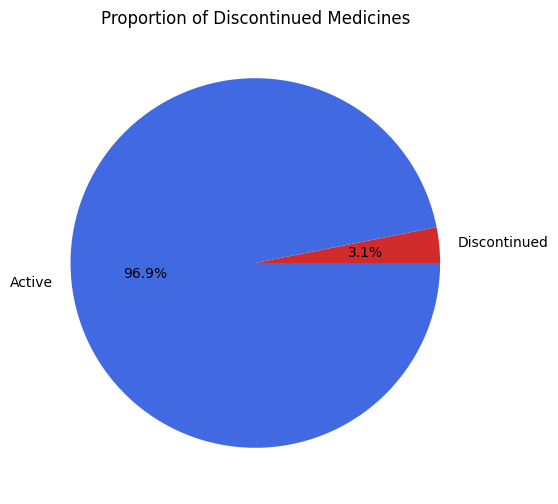

In [49]:
# Menghitung obat yang discontinued
discontinued_counts = df[df['Is_discontinued'] == True ].shape[0]

# Menghitung total obat
total_counts = df.shape[0]

# Menghitung proporsi obat yang discontinued
discontinued_percentage = (discontinued_counts / total_counts) * 100
colors = ['#D22B2B','#4169E1']

# Membuat pie chart
plt.figure(figsize=(8, 6))
plt.pie([discontinued_percentage, 100 - discontinued_percentage], labels=['Discontinued', 'Active'], autopct='%1.1f%%', colors=colors)
plt.title('Proportion of Discontinued Medicines')
plt.show()

In [50]:
df_dis = df[df['Is_discontinued']==True]
df_dis.head()

,name,price(₹),Is_discontinued,manufacturer_name,type,pack_size_label,primary_comp,entire_comp,value,entire_value,...,use3,use4,Chemical Class,Habit Forming,Therapeutic Class,Action Class,main_subs,other_subs,sideeffects,use
31,atarax syrup,110.25,True,Dr Reddy's Laboratories Ltd,syrup,bottle of 100 ml Syrup,hydroxyzine,hydroxyzine,10mg,10mg,...,NaN,NaN,Piperazine Derivative,No,RESPIRATORY,H1 Antihistaminics (First Generation),Hydil 10mg Syrup,"Livrox 10mg Syrup, Anzine 10mg Syrup, Pru 10mg...","Nausea, Constipation, Upset stomach, Sedation,...",anxiety skinconditionswithinflammation&itching
35,alkasol oral solution,122.05,True,Stadmed Pvt Ltd,solution,bottle of 100 ml Oral Solution,disodium hydrogen citrate,disodium hydrogen citrate,1.4gm/5ml,1.4gm/5ml,...,NaN,NaN,Carboxylic acid derivative,No,UROLOGY,Uricosuric agent-gout,Uridol Oral Solution,,"Stomach pain, Nausea, Tiredness, Frequent urge...",gout kidneystone
48,amoxycillin 500mg capsule,31.90,True,Jagsonpal Pharmaceuticals Ltd,capsule,strip of 10 capsules,amoxycillin,amoxycillin,500mg,500mg,...,NaN,NaN,Aminopenicillins {Penicillins},No,ANTI INFECTIVES,Cell wall active agent -Extended spectrum Peni...,Tormoxin 500mg Capsule,"SB Mox 500mg Capsule, Cipmox 500 Capsule, Tido...","Rash, Nausea, Allergic reaction, Vomiting, Dia...",bacterialinfections
70,amikacin sulphate 500mg injection,11.87,True,Sun Pharmaceutical Industries Ltd,injection,vial of 2 ml Injection,amikacin,amikacin,500mg,500mg,...,NaN,NaN,Aminoglycosides,No,OPHTHAL,Aminoglycosides,Amilab 500mg Injection,"Mika Best 500mg Injection, Emica 500mg Injecti...","Increased blood urea, Injection site reactions...",bacterialinfections
74,azoran tablet,106.65,True,RPG Life Sciences Ltd,tablet,strip of 10 tablets,azathioprine,azathioprine,50mg,50mg,...,NaN,NaN,"Nucleoside Analog, and Purines",No,ANTI NEOPLASTICS,Immunosuppressant- Purine analogs,Transimune 50mg Tablet,"Zesoris-AZ 50mg Tablet, Azawan Tablet, Autorin...","Increased bleeding tendency, Nausea, Loss of a...",organrejectionintransplantpatients rheumatoida...


In [51]:
initial_column = 'Action Class'
counts = df_dis[initial_column].value_counts()[:5]

color_start = 'rgb(76, 75, 22)'
color_end = 'rgb(247, 241, 229)'
fig = px.bar(az, x=counts.index, y=counts.values,color=counts.values, color_continuous_scale='sunset')

fig.update_layout(
    title='Distribution of Features',
    xaxis_title=' ',
    yaxis_title='Count',
    plot_bgcolor='white'
)
fig.update_layout(barmode='group')
columns = ['Action Class','Chemical Class','Therapeutic Class', 'use0','primary_comp',	'entire_comp','Habit Forming']
buttons = []
for column in columns:
    button = dict(
        label=column,
        method='update',
        args=[{'y': [df_dis[column].value_counts()[:5].values], 'x':[df_dis[column].value_counts()[:5].index], 'title':f'Counts of Unique Values in {column}' }],
        args2=[{'name': column}],
    )
    buttons.append(button)

fig.update_layout(
    updatemenus=[
        dict(
            buttons=buttons,
            direction='down',
            showactive=True
        )
    ]
)

fig.show()

Berdasarkan Action Class,


*   Fluoroquinolone mempunyai risiko efek samping yang serius. FDA menyarankan bahwa  Fluoroquinolone tidak cocok untuk kondisi umum seperti sinusitis, bronkitis, dan infeksi saluran kemih tanpa komplikasi, dan hanya boleh dipertimbangkan untuk digunakan jika pengobatan dengan antibiotik lain yang kurang beracun telah gagal. [Source](https://www.drugs.com/drug-class/quinolones.html)

*   Cephalosporins, para ilmuwan meningkatkan struktur dari cephalosporins agar lebih efektif dalam menangani berbagai macam bakteri. Hingga saat ini, sudah ada 5 generasi cephalosporins. Kemungkinan obat tidak lanjut diproduksi karena adanya perubahan dari generasi Cephalosporins yang ingin digunakan. [Source](https://www.drugs.com/drug-class/cephalosporins.html)






## Side Effects

In [52]:
# Jumlah side effect dan use
df2 = df
df2['sides'] = 0

for i in range(42):  # 42 columns dari sideEffect0 sampai sideEffect41
    col_name = f'sideEffect{i}'
    df2['sides'] += (~df2[col_name].isna()).astype(int)

df2['uses'] = 0

for i in range(5):
    col_name = f'use{i}'
    df2['uses'] += (~df2[col_name].isna()).astype(int)

df2.head()

,name,price(₹),Is_discontinued,manufacturer_name,type,pack_size_label,primary_comp,entire_comp,value,entire_value,...,Chemical Class,Habit Forming,Therapeutic Class,Action Class,main_subs,other_subs,sideeffects,use,sides,uses
0,augmentin 625 duo tablet,223.42,False,Glaxo SmithKline Pharmaceuticals Ltd,tablet,strip of 10 tablets,amoxycillin,amoxycillin clavulanicacid,500mg,500mg 125mg,...,NaN,No,ANTI INFECTIVES,NaN,Penciclav 500 mg/125 mg Tablet,"Moxiforce-CV 625 Tablet, Fightox 625 Tablet, N...","Vomiting, Nausea, Diarrhea",bacterialinfections,3,1
1,azithral 500 tablet,132.36,False,Alembic Pharmaceuticals Ltd,tablet,strip of 5 tablets,azithromycin,azithromycin,500mg,500mg,...,Macrolides,No,ANTI INFECTIVES,Macrolides,Zithrocare 500mg Tablet,"Cazithro 500mg Tablet, Azax 500 Tablet, Zady 5...","Vomiting, Nausea, Diarrhea, Abdominal pain",bacterialinfections,4,1
2,ascoril ls syrup,118.00,False,Glenmark Pharmaceuticals Ltd,syrup,bottle of 100 ml Syrup,ambroxol,ambroxol levosalbutamol,30mg/5ml,30mg/5ml 1mg/5ml,...,NaN,No,RESPIRATORY,NaN,Solvin LS Syrup,"Zerotuss XP Syrup, Capex LS Syrup, Ambrodil-LX...","Dizziness, Stomach pain, Tremors, Headache, Ra...",coughwithmucus,14,1
3,allegra 120mg tablet,218.81,False,Sanofi India Ltd,tablet,strip of 10 tablets,fexofenadine,fexofenadine,120mg,120mg,...,Diphenylmethane Derivative,No,RESPIRATORY,H1 Antihistaminics (second Generation),Lcfex Tablet,"Fexise 120mg Tablet, Histafree 120 Tablet, Nex...","Drowsiness, Dizziness, Nausea, Headache",sneezingandrunnynoseduetoallergies allergiccon...,4,2
4,avil 25 tablet,10.96,False,Sanofi India Ltd,tablet,strip of 15 tablets,pheniramine,pheniramine,25mg,25mg,...,Pyridines Derivatives,No,RESPIRATORY,H1 Antihistaminics (First Generation),Eralet 25mg Tablet,,"Dryness in mouth, Sleepiness",allergicconditions,2,1


<Figure size 1200x600 with 0 Axes>

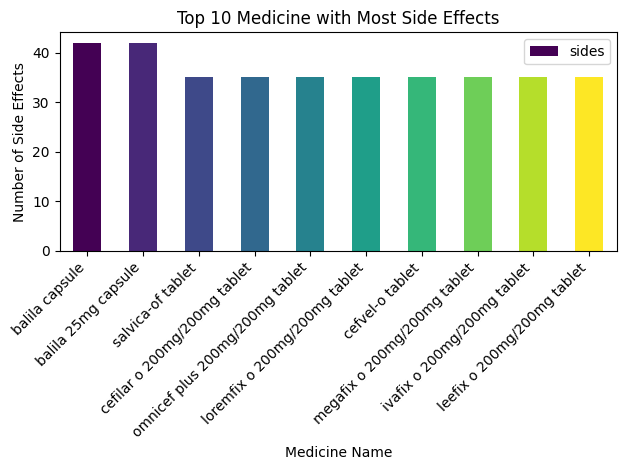

In [53]:
plt.figure(figsize=(12, 6))
colors = plt.cm.viridis(np.linspace(0, 1, 10))
df2[['name', 'sides']].sort_values('sides', ascending=False).head(10).plot(kind='bar', x='name', y='sides', color=colors)
plt.title('Top 10 Medicine with Most Side Effects')
plt.xlabel('Medicine Name')
plt.ylabel('Number of Side Effects')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [54]:
top_10_side_effects = df2[['name', 'sides']].sort_values('sides', ascending=False).head(10)['name'].tolist()
df_su= df2[df2['name'].isin(top_10_side_effects)]
df_su

initial_column = 'use0'
counts = df_su[initial_column].value_counts()[:5]

color_start = 'rgb(76, 75, 22)'
color_end = 'rgb(247, 241, 229)'
fig = px.bar(az, x=counts.index, y=counts.values,color=counts.values, color_continuous_scale='sunset')

fig.update_layout(
    title='Distribution of Features',
    xaxis_title='Unique Values',
    yaxis_title='Count',
    plot_bgcolor='white'
)
fig.update_layout(barmode='group')
columns = ['use0','Chemical Class','Therapeutic Class', 'Action Class','primary_comp',	'entire_comp']
buttons = []
for column in columns:
    button = dict(
        label=column,
        method='update',
        args=[{'y': [df_su[column].value_counts()[:5].values], 'x':[df_su[column].value_counts()[:5].index], 'title':f'Counts of Unique Values in {column}' }],
        args2=[{'name': column}],
    )
    buttons.append(button)

fig.update_layout(
    updatemenus=[
        dict(
            buttons=buttons,
            direction='down',
            showactive=True
        )
    ]
)

fig.show()

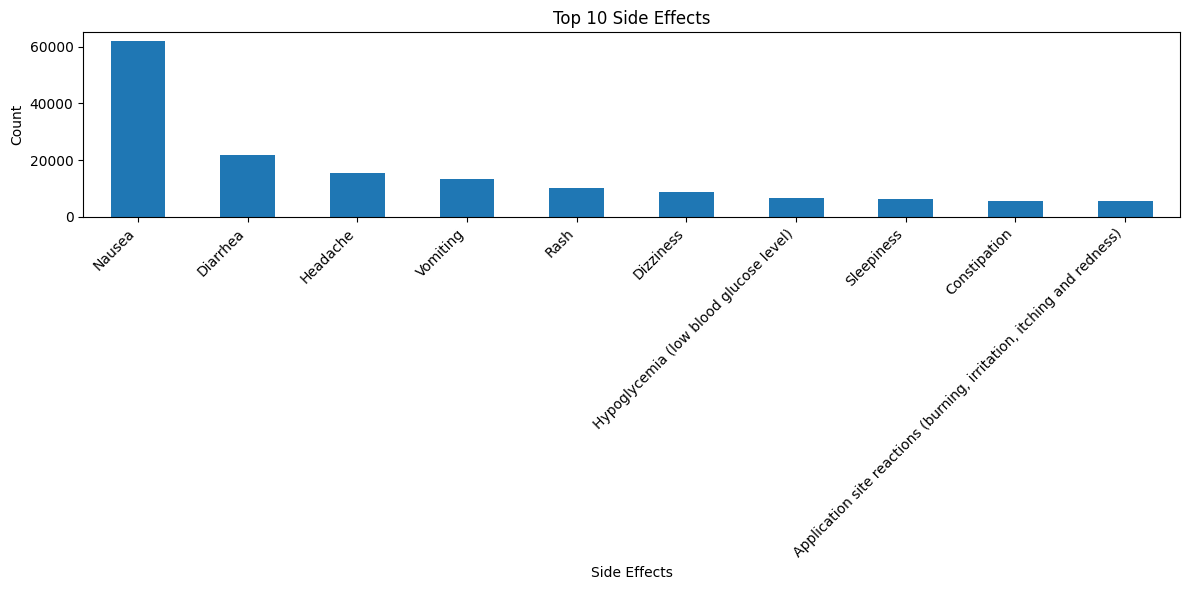

In [55]:
plt.figure(figsize=(12, 6))
df['sideEffect0'].value_counts().nlargest(10).plot(kind='bar')
plt.title('Top 10 Side Effects')
plt.xlabel('Side Effects')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Top 10 Medicine

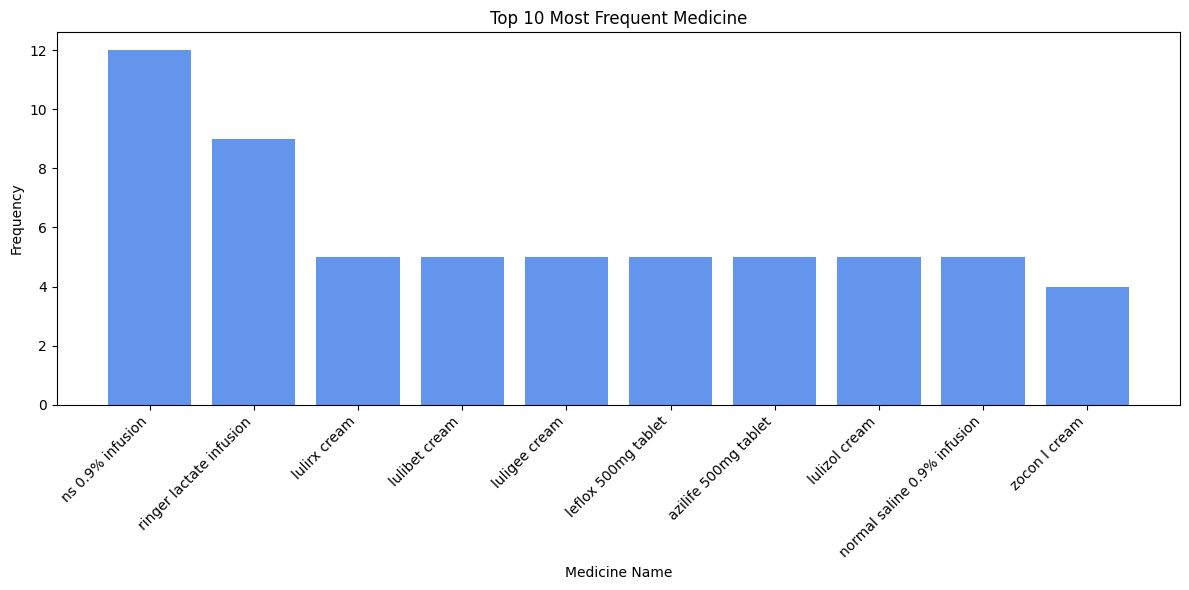

In [56]:
top_10_medicine = df['name'].value_counts().nlargest(10)

plt.figure(figsize=(12, 6))
plt.bar(top_10_medicine.index, top_10_medicine.values, color='#6495ED')
plt.title('Top 10 Most Frequent Medicine')
plt.xlabel('Medicine Name')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [57]:
top_10_meds = df['name'].value_counts().nlargest(10).index.tolist()
df_top_10 = df[df['name'].isin(top_10_meds)]
df_use = df_top_10[['name', 'use0']]
df_use['use0'].value_counts()

,count
use0,
short term fluid replacement after trauma,26
fungal skin infections,24
bacterial infections,10


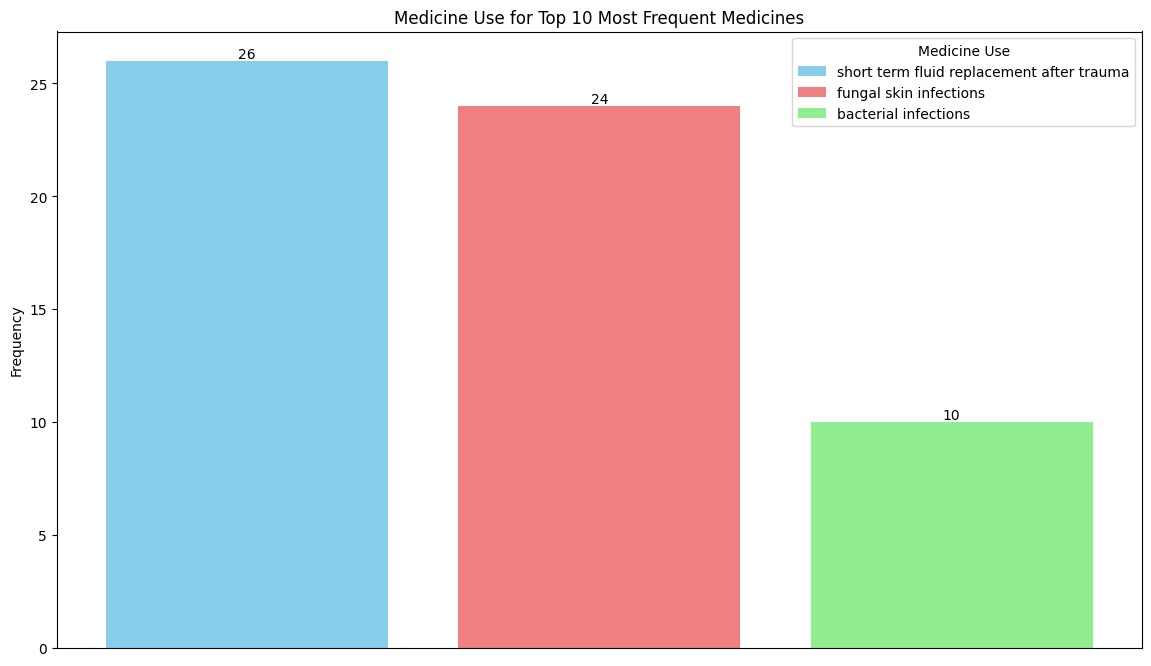

In [58]:
# Menghitung value dari use
counts = df_use['use0'].value_counts()

# Membuat bar chart
plt.figure(figsize=(14, 8))
bars = plt.bar(counts.index, counts.values, color=['skyblue', 'lightcoral', 'lightgreen','violet'])

# Menambahkan jumlah value di atas setiap bar
for bar, count in zip(bars.patches, counts.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_y() + bar.get_height(), f'{count}', ha='center', va='bottom')

# Menghapus label pada x-axis
plt.xticks([])

# Membuat legend
plt.legend(bars, counts.index, title='Medicine Use')
plt.title('Medicine Use for Top 10 Most Frequent Medicines')
plt.ylabel('Frequency')
plt.show()

Obat yang banyak beredar terkait untuk infeksi bakteri dan infeksi jamur pada kulit. Short term fluid replacement seperti ns 0.9% infusion adalah infus yang banyak digunakan.

# Feature Engineering & Hyperparameter Tuning

In [59]:
df_fin = df_final.sample(frac=0.1, random_state=42)

In [60]:
# Fungsi untuk menghasilkan word embedding pada setiap kolom
def generate_word_embeddings(column):
    unique_values = df_fin[column].unique()
    sentences = [[value] for value in unique_values]
    model = Word2Vec(sentences, min_count=1, vector_size=100)
    return model

# Menyimpan kolom yang ingin dilakukan word embedding
text_columns = ['type','primary_comp', 'entire_comp','value','entire_value','use']

# Dictionary untuk menyimpan model
word_embedding_models = {}

for column in text_columns:
    model = generate_word_embeddings(column)
    word_embedding_models[column] = model

for column, model in tqdm(word_embedding_models.items(), desc="embeddings"):
    df_fin[column + '_embeddings'] = df_fin[column].apply(lambda x: np.round(model.wv[x].reshape(1, -1), 4) if x in model.wv else [])

embeddings: 100%|██████████| 6/6 [00:02<00:00,  2.91it/s]


In [61]:
df_fin

,name,type,primary_comp,entire_comp,value,entire_value,use,type_embeddings,primary_comp_embeddings,entire_comp_embeddings,value_embeddings,entire_value_embeddings,use_embeddings
30797,bdpoma 1mg capsule,capsule,pomalidomide,pomalidomide,1mg,1mg,multiplemyeloma,"[[-0.0012, -0.0024, -0.0018, -0.0012, -0.0065,...","[[-0.0035, -0.0031, 0.0051, 0.01, -0.0067, -0....","[[-0.0021, -0.0054, -0.0089, -0.0015, -0.0076,...","[[-0.0034, 0.0052, 0.003, 0.0017, 0.0007, -0.0...","[[-0.0006, -0.007, -0.0011, 0.009, -0.0057, 0....","[[0.0078, -0.0042, 0.0051, -0.0056, 0.0031, -0..."
174986,prestoheal ds tablet,tablet,bromelain,bromelain rutoside,180mg,180mg 200mg,painrelief,"[[-0.0025, -0.0059, 0.0075, -0.0073, -0.009, -...","[[-0.0025, -0.0096, -1e-04, 0.0019, 0.0002, 0....","[[0.0092, -0.009, -0.0066, -0.0075, 0.0092, -0...","[[0.0035, 0.0077, 0.0059, 0.0085, 0.0064, 0.00...","[[-0.0084, 0.0054, -0.006, 0.0024, -0.0008, 0....","[[0.0077, -0.0038, 0.0073, 0.007, 0.0036, -0.0..."
55160,cadiceft 250mg injection,injection,ceftriaxone,ceftriaxone,250mg,250mg,bacterialinfections,"[[-0.0002, 0.0042, 0.0021, 0.01, 0.0006, -0.00...","[[0.0053, 0.0049, 0.0058, -0.002, 0.0075, -0.0...","[[0.0019, 0.0067, -0.003, -0.0088, 0.0017, -0....","[[-0.0015, 0.0046, 0.0016, 0.0061, 0.0006, -0....","[[-0.0036, -0.0005, -0.0039, 0.009, -0.0012, -...","[[0.0048, 0.0021, -0.0051, -0.009, -0.0064, -0..."
221255,toplift xl 37.5mg capsule sr,capsule,venlafaxine,venlafaxine,37.5mg,37.5mg,depression anxietydisorder,"[[-0.0012, -0.0024, -0.0018, -0.0012, -0.0065,...","[[0.0014, -0.0034, 0.007, -0.0014, 0.0078, -0....","[[0.0077, -0.0043, 0.0014, -0.0077, -0.0057, 0...","[[-0.0072, -0.0093, -0.0039, 0.0094, -0.0039, ...","[[-0.0054, 0.0078, -0.0086, -0.0081, 0.0034, -...","[[-0.0068, -0.0069, -0.0093, 0.003, 0.0016, 0...."
132807,laurunam 1000mg injection,injection,meropenem,meropenem,1000mg,1000mg,severebacterialinfections,"[[-0.0002, 0.0042, 0.0021, 0.01, 0.0006, -0.00...","[[0.0028, -0.0095, -0.004, -0.0092, 0.002, -0....","[[-0.0039, 0.003, -0.0038, -0.0042, -0.0031, 0...","[[0.0079, 0.0097, 0.0004, 0.0015, 0.0032, -0.0...","[[-0.0043, -0.0049, -0.0023, 0.0012, 0.0043, 0...","[[-0.0092, -0.0094, -0.0025, 0.0012, 0.0017, 0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
150512,newtel-h 40 tablet,tablet,telmisartan,telmisartan hydrochlorothiazide,40mg,40mg 12.5mg,hypertension(highbloodpressure),"[[-0.0025, -0.0059, 0.0075, -0.0073, -0.009, -...","[[0.0036, -0.0096, -0.0026, -0.0097, -0.008, 0...","[[-0.0097, 0.0033, -0.0069, 0.0061, -0.0027, 0...","[[-0.0048, 0.0069, -0.0071, -0.0061, -0.0051, ...","[[-0.0096, 0.0012, 0.0005, 0.0005, 0.0054, 0.0...","[[0.0041, 0.0019, -0.0059, -0.0027, -0.0043, -..."
64771,dolzy mr 250mg/50mg/325mg tablet,tablet,chlorzoxazone,chlorzoxazone diclofenac,250mg,250mg 50mg,painduetomusclespasm,"[[-0.0025, -0.0059, 0.0075, -0.0073, -0.009, -...","[[-0.0021, 0.0025, -1e-04, -0.0093, 0.0023, 0....","[[-0.0066, -0.0038, -0.0073, 0.0009, -0.0033, ...","[[-0.0015, 0.0046, 0.0016, 0.0061, 0.0006, -0....","[[-0.0026, -0.0098, 0.0077, -0.0063, -0.0002, ...","[[-0.0019, 0.0024, 0.0016, 0.0002, 0.002, -0.0..."
234242,valirab-dsr capsule,capsule,domperidone,domperidone rabeprazole,30mg,30mg 20mg,gastroesophagealrefluxdisease(acidreflux) pept...,"[[-0.0012, -0.0024, -0.0018, -0.0012, -0.0065,...","[[0.0054, 0.008, 0.006, -0.0014, 0.0078, 0.007...","[[0.007, -0.0039, 0.0085, -0.0097, -0.0064, -0...","[[0.002, -0.0006, 0.0075, 0.0004, -0.0026, 0.0...","[[0.0099, -0.0093, -0.0032, 0.0021, -0.0022, -...","[[-0.0054, -0.0075, -0.0058, -0.0057, 0.0036, ..."
68692,dize 5mg tablet,tablet,diazepam,diazepam,5mg,5mg,shorttermanxiety alcoholwithdrawal musclespasm...,"[[-0.0025, -0.0059, 0.0075, -0.0073, -0.009, -...","[[-0.0077, -0.0009, 0.0093, 0.003, 0.0016, -0....","[[-0.0048, -0.0043, -0.0048, -0.0098, -0.0008,...","[[-0.0028, -0.0041, -0.0067, 0.0033, -0.0097, ...","[[0.0039, -0.0029, -0.0035, 0.0057, 0.0096, -0...","[[0.0092, -0.009, -0.0066, -0.0075

In [62]:
# Dapat disesuaikan dengan preferensi masing-masing
weightage = {
    'type_embeddings': 0.1,
    'primary_comp_embeddings': 0.1,
    'entire_comp_embeddings':0.3,
    'value_embeddings': 0.1,
    'entire_value_embeddings': 0.1,
    'use_embeddings' : 0.3
}

In [63]:
# Menghitung similarity scores untuk kolom text menggunakan cosine similarity
def calculate_text_similarity(value1, value2):
    similarity = cosine_similarity(value1, value2)
    return similarity[0][0]

# Menghitung weighted similarity antara dua obat
def calculate_weighted_similarity(medicine1, medicine2):
    similarity_scores = []
    for column, weight in weightage.items():
        similarity = calculate_text_similarity(medicine1[column].values[0], medicine2[column])
        similarity_scores.append(similarity * weight)
    weighted_similarity = sum(similarity_scores)
    return weighted_similarity

In [64]:
# Fungsi untuk mencari obat yang similar
def get_similar_medicines(medicine_name):
    medicine = df_fin[df_fin['name'] == medicine_name]
    if medicine.empty:
        return "Medicine not found"

    if medicine['primary_comp'].values[0] == medicine['entire_comp'].values[0].rstrip():
        del weightage['primary_comp_embeddings']

    if medicine['value'].values[0] == medicine['entire_value'].values[0].rstrip():
        del weightage['value_embeddings']

    new_dataset = df_fin.copy(deep=True)
    new_dataset['similarity_score'] = df_fin.apply(lambda x: calculate_weighted_similarity(medicine, x), axis=1)
    top_10_similar_medicines = new_dataset.nlargest(11, 'similarity_score')[1:]
    return top_10_similar_medicines[['name', 'similarity_score']]

nama yang di dalam kurung dapat diganti sesuai dengan obat yang ingin dicari rekomendasinya

In [65]:
similar_medicines = get_similar_medicines('laurunam 1000mg injection')
print('Top 10 Similar Medicine')
print(similar_medicines)

Top 10 Similar Medicine
                              name  similarity_score
148290     meropect 1000 injection               0.8
148695   merosler 1000mg injection               0.8
142276   my penum 1000mg injection               0.8
149475    mepwell 1000mg injection               0.8
10342     aspenem 1000mg injection               0.8
182804    peronum 1000mg injection               0.8
141544          meroclay injection               0.8
28829     biopect 1000mg injection               0.8
149625   merogoog 1000mg injection               0.8
146275  meroclass 1000mg injection               0.8


untuk melihat apakah obat yang direkomendasikan relevan

In [66]:
recommended_names = similar_medicines['name'].tolist()
df_fin[df_fin['name'].isin(recommended_names)]

,name,type,primary_comp,entire_comp,value,entire_value,use,type_embeddings,primary_comp_embeddings,entire_comp_embeddings,value_embeddings,entire_value_embeddings,use_embeddings
148290,meropect 1000 injection,injection,meropenem,meropenem,1000mg,1000mg,severebacterialinfections,"[[-0.0002, 0.0042, 0.0021, 0.01, 0.0006, -0.00...","[[0.0028, -0.0095, -0.004, -0.0092, 0.002, -0....","[[-0.0039, 0.003, -0.0038, -0.0042, -0.0031, 0...","[[0.0079, 0.0097, 0.0004, 0.0015, 0.0032, -0.0...","[[-0.0043, -0.0049, -0.0023, 0.0012, 0.0043, 0...","[[-0.0092, -0.0094, -0.0025, 0.0012, 0.0017, 0..."
148695,merosler 1000mg injection,injection,meropenem,meropenem,1000mg,1000mg,severebacterialinfections,"[[-0.0002, 0.0042, 0.0021, 0.01, 0.0006, -0.00...","[[0.0028, -0.0095, -0.004, -0.0092, 0.002, -0....","[[-0.0039, 0.003, -0.0038, -0.0042, -0.0031, 0...","[[0.0079, 0.0097, 0.0004, 0.0015, 0.0032, -0.0...","[[-0.0043, -0.0049, -0.0023, 0.0012, 0.0043, 0...","[[-0.0092, -0.0094, -0.0025, 0.0012, 0.0017, 0..."
142276,my penum 1000mg injection,injection,meropenem,meropenem,1000mg,1000mg,severebacterialinfections,"[[-0.0002, 0.0042, 0.0021, 0.01, 0.0006, -0.00...","[[0.0028, -0.0095, -0.004, -0.0092, 0.002, -0....","[[-0.0039, 0.003, -0.0038, -0.0042, -0.0031, 0...","[[0.0079, 0.0097, 0.0004, 0.0015, 0.0032, -0.0...","[[-0.0043, -0.0049, -0.0023, 0.0012, 0.0043, 0...","[[-0.0092, -0.0094, -0.0025, 0.0012, 0.0017, 0..."
149475,mepwell 1000mg injection,injection,meropenem,meropenem,1000mg,1000mg,severebacterialinfections,"[[-0.0002, 0.0042, 0.0021, 0.01, 0.0006, -0.00...","[[0.0028, -0.0095, -0.004, -0.0092, 0.002, -0....","[[-0.0039, 0.003, -0.0038, -0.0042, -0.0031, 0...","[[0.0079, 0.0097, 0.0004, 0.0015, 0.0032, -0.0...","[[-0.0043, -0.0049, -0.0023, 0.0012, 0.0043, 0...","[[-0.0092, -0.0094, -0.0025, 0.0012, 0.0017, 0..."
10342,aspenem 1000mg injection,injection,meropenem,meropenem,1000mg,1000mg,severebacterialinfections,"[[-0.0002, 0.0042, 0.0021, 0.01, 0.0006, -0.00...","[[0.0028, -0.0095, -0.004, -0.0092, 0.002, -0....","[[-0.0039, 0.003, -0.0038, -0.0042, -0.0031, 0...","[[0.0079, 0.0097, 0.0004, 0.0015, 0.0032, -0.0...","[[-0.0043, -0.0049, -0.0023, 0.0012, 0.0043, 0...","[[-0.0092, -0.0094, -0.0025, 0.0012, 0.0017, 0..."
182804,peronum 1000mg injection,injection,meropenem,meropenem,1000mg,1000mg,severebacterialinfections,"[[-0.0002, 0.0042, 0.0021, 0.01, 0.0006, -0.00...","[[0.0028, -0.0095, -0.004, -0.0092, 0.002, -0....","[[-0.0039, 0.003, -0.0038, -0.0042, -0.0031, 0...","[[0.0079, 0.0097, 0.0004, 0.0015, 0.0032, -0.0...","[[-0.0043, -0.0049, -0.0023, 0.0012, 0.0043, 0...","[[-0.0092, -0.0094, -0.0025, 0.0012, 0.0017, 0..."
141544,meroclay injection,injection,meropenem,meropenem,1000mg,1000mg,severebacterialinfections,"[[-0.0002, 0.0042, 0.0021, 0.01, 0.0006, -0.00...","[[0.0028, -0.0095, -0.004, -0.0092, 0.002, -0....","[[-0.0039, 0.003, -0.0038, -0.0042, -0.0031, 0...","[[0.0079, 0.0097, 0.0004, 0.0015, 0.0032, -0.0...","[[-0.0043, -0.0049, -0.0023, 0.0012, 0.0043, 0...","[[-0.0092, -0.0094, -0.0025, 0.0012, 0.0017, 0..."
28829,biopect 1000mg injection,injection,meropenem,meropenem,1000mg,1000mg,severebacterialinfections,"[[-0.0002, 0.0042, 0.0021, 0.01, 0.0006, -0.00...","[[0.0028, -0.0095, -0.004, -0.0092, 0.002, -0....","[[-0.0039, 0.003, -0.0038, -0.0042, -0.0031, 0...","[[0.0079, 0.0097, 0.0004, 0.0015, 0.0032, -0.0...","[[-0.0043, -0.0049, -0.0023, 0.0012, 0.0043, 0...","[[-0.0092, -0.0094, -0.0025, 0.0012, 0.0017, 0..."
149625,merogoog 1000mg injection,injection,meropenem,meropenem,1000mg,1000mg,severebacterialinfections,"[[-0.0002, 0.0042, 0.0021, 0.01, 0.0006, -0.00...","[[0.0028, -0.0095, -0.004, -0.0092, 0.002, -0....","[[-0.0039, 0.003, -0.0038, -0.0042, -0.0031, 0...","[[0.0079, 0.0097, 0.0004, 0.0015, 0.0032, -0.0...","[[-0.0043, -0.0049, -0.0023, 0.0012, 0.0043, 0...","[[-0.0092, -0.0094, -0.0025, 0.0012, 0.0017, 0..."
146275,meroclass 1000mg injection,injection,meropenem,meropenem,1000mg,1000mg,severebacterialinfection